# Swithching Power e Conduction Power (Testing)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def detectCommutation(y):
    y1 = y[:-1]
    y2 = y[1:]
    
    diff = y2 - y1
    
    return y1, y2, diff


def tableSwitchingLosses3(switch_s1, switch_s2, current, duration, 
                          eon1, eoff1, erec1, eon2, eoff2, erec2):
    '''
        Table with Switching Losses for TDD NPC 3-Levels.
        Curves:
            * eon_params1, eoff_params1 and erec_params1: IGBT1/DIODE5
            * eon_params2, eoff_params2 and erec_params2: IGBT2/DIODE1
        Based in a Semikron Manual, SKiM301MLI12E4
    '''

    switch_s1 = np.array(switch_s1)
    switch_s2 = np.array(switch_s2)
    
    current = np.array(current)
    
    _, _, commut1 = detectCommutation(switch_s1)
    _, _, commut2 = detectCommutation(switch_s2)
    
    stateA = np.zeros(commut1.size)
    stateB = np.zeros(commut1.size)
    stateC = np.zeros(commut1.size)
    stateD = np.zeros(commut1.size)
    
    stateA[commut1 == 1] = 1
    stateB[commut1 == -1] = 1
    stateC[commut2 == -1] = 1
    stateD[commut2 == 1] = 1
    
    current0 = current[1:]
    
    current_pos = current0 >= 0
    current_neg = current0 < 0
    
    stateA_cur_pos = stateA * current_pos
    stateA_cur_neg = stateA * current_neg
        
    stateB_cur_pos = stateB * current_pos
    stateB_cur_neg = stateB * current_neg
    
    stateC_cur_pos = stateC * current_pos
    stateC_cur_neg = stateC * current_neg
    
    stateD_cur_pos = stateD * current_pos
    stateD_cur_neg = stateD * current_neg

    # For 'S1'
    s1_eon  = eon1(stateA_cur_pos)
    s1_eoff = eoff1(stateB_cur_pos)
    
    # For 'S2'
    s2_eon  = eon2(stateD_cur_pos)
    s2_eoff = eoff2(stateC_cur_pos)
    
    # For 'S3'
    s3_eon  = eon2(stateB_cur_neg)
    s3_eoff = eoff2(stateA_cur_neg)
    
    # For 'S4'
    s4_eon  = eon1(stateC_cur_neg)
    s4_eoff = eoff1(stateD_cur_neg)

    ###
    
    # For 'D1'
    d1_rec = erec2(stateB_cur_neg)
    
    # For 'D4'
    d4_rec = erec2(stateD_cur_pos)
    
    # For 'D5'
    d5_rec = erec1(stateA_cur_pos)
    
    # For 'D6'
    d6_rec = erec1(stateC_cur_neg)
    
    P_sw = {
        'S1': 1/duration * (np.sum(s1_eoff) + np.sum(s1_eon)),
        'S2': 1/duration * (np.sum(s2_eoff) + np.sum(s2_eon)),
        'S3': 1/duration * (np.sum(s3_eoff) + np.sum(s3_eon)),
        'S4': 1/duration * (np.sum(s4_eoff) + np.sum(s4_eon)),
        
        'D1': 1/duration * (np.sum(d1_rec)),
        'D4': 1/duration * (np.sum(d4_rec)),
        
        'D5': 1/duration * (np.sum(d5_rec)),
        'D6': 1/duration * (np.sum(d6_rec))}
    
    return P_sw, ((stateA, stateB, stateC, stateD),
                  (current_pos, current_neg),
                  ((stateA_cur_pos, stateA_cur_neg),
                   (stateB_cur_pos, stateB_cur_neg),
                   (stateC_cur_pos, stateC_cur_neg),
                   (stateD_cur_pos, stateD_cur_neg),))

## Testing the Switching Losses
### 1. Testando a detecção de comutação

In [15]:
import numpy as np
import matplotlib.pyplot as plt

y = np.array(list('AABBBBCCBBBAABBAABBBCCCBBBCC'))

index1 = y == 'A'
index2 = y == 'B'
index3 = y == 'C'

s1 = np.zeros(len(y))
s2 = np.zeros(len(y))
s3 = np.zeros(len(y))
s4 = np.zeros(len(y))

s1[index1] = 1
s2[index1] = 1

s2[index2] = 1
s3[index2] = 1

s3[index3] = 1
s4[index3] = 1

print('Trocas de Estado:')

print(' S2 !S1  ->  S1  S2: %3d'   % 2)
print(' S1  S2  ->  S2 !S1: %3d'  % 3)
print(' S2 !S1  -> !S1 !S2: %3d' % 3)
print('!S1 !S2  ->  S2 !S1: %3d'  % 2)

Trocas de Estado:
 S2 !S1  ->  S1  S2:   2
 S1  S2  ->  S2 !S1:   3
 S2 !S1  -> !S1 !S2:   3
!S1 !S2  ->  S2 !S1:   2


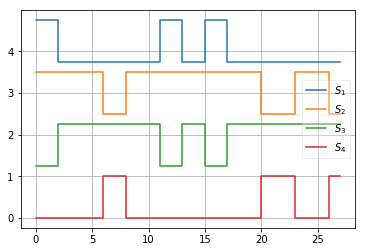

In [16]:
plt.step(range(s1.size), s1+3.75, where='post', label='$S_1$')
plt.step(range(s2.size), s2+2.5, where='post', label='$S_2$')
plt.step(range(s3.size), s3+1.25, where='post', label='$S_3$')
plt.step(range(s4.size), s4, where='post', label='$S_4$')
plt.legend(loc=7, framealpha=.3)
xmin, _ = plt.xlim()
plt.grid()
plt.show()

### 2. Mostrando o sinal simulado para o teste de perdas de comutação

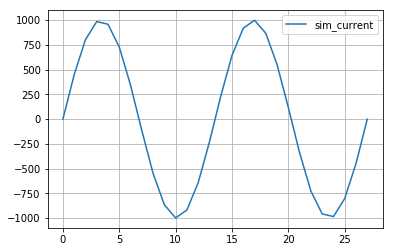

In [17]:
size = y.size

t = np.linspace(0, 2/60, size)
sim_current = 1000*np.sin(2*np.pi*60*t)

plt.plot(sim_current, label='sim_current')
plt.grid(True)
plt.legend()
plt.show()

#### 2.1 Obtendo os parâmetros para as funções

In [18]:
# import webbrowser

# webbrowser.open('file:///C:/Users/tiarl/Desktop/Projetos%20GEPOC/' +
#                'Github%20GEPOC/TDD_3-level/input/References/' +
#                'SEMIKRON_DataSheet_SKiM301MLI12E4_23918880.pdf')

In [19]:
# Manual da Semikron (SKiM301MLI12E4)

# Curvas da Fig. 3: Typ. IGBT1 & Diode5 turn-on /-off energy = f (IC)

Ic_pts1   = [150., 200. , 300. , 400., 500., 600.]

eon_pts1  = [ 10.,  14. ,  22.5,  36., 55. ,  70.]
erec_pts1 = [ 15.,  17.5,  24. ,  26., 27.5,  29.]
eoff_pts1 = [ 20.,  25. ,  34. ,  43., 52. ,  61.]

eon_params1  = np.polyfit(Ic_pts1, eon_pts1,  3) / 1e3
eoff_params1 = np.polyfit(Ic_pts1, eoff_pts1, 3) / 1e3
erec_params1 = np.polyfit(Ic_pts1, erec_pts1, 3) / 1e3

eon1  = np.poly1d(eon_params1)
eoff1 = np.poly1d(eoff_params1)
erec1 = np.poly1d(erec_params1)

# Curvas da Fig. 15: Typ. IGBT2 & Diode1 turn-on /-off energy = f (IC)

Ic_pts2   = [150., 200. , 300. , 400., 500., 600.]

eon_pts2  = [  5.,  7. ,  11. ,  15., 19. ,  23.]
erec_pts2 = [ 15.,  17.,  22.5,  25., 27.5,  31.]
eoff_pts2 = [ 20.,  25. , 36. ,  47., 58. ,  69.]

eon_params2  = np.polyfit(Ic_pts2, eon_pts2,  3) / 1e3
eoff_params2 = np.polyfit(Ic_pts2, eoff_pts2, 3) / 1e3
erec_params2 = np.polyfit(Ic_pts2, erec_pts2, 3) / 1e3

eon2  = np.poly1d(eon_params2)
eoff2 = np.poly1d(eoff_params2)
erec2 = np.poly1d(erec_params2)

### 3. Parametrizando as curvas $E_{on}$, $E_{off}$ e $E_{rec}$, retiradas de um manual da Semikron para o teste das perdas em comutação com os sinais acima

In [20]:
# Parâmetros de um manual da Semikron (SKiM301MLI12E4)

np.set_printoptions(precision=2)

print('Typ. IGBT1 & Diode5')
print('eon_params:', eon_params1)
print('eoff_params:', eoff_params1)
print('erec_params:', erec_params1)

print('\nTyp. IGBT2 & Diode1')
print('eon_params:', eon_params2)
print('eoff_params:', eoff_params2)
print('erec_params:', erec_params2)

Vcc = 600
C:\Users\tiarl\Desktop\GEPOC\Github GEPOC\TDD_3-level\interface_module3.py
Vo_IGBT1 = 2.05 # [V]
Ro_IGBT1 = 3.8*1e-3 # [ohm]

Vo_IGBT2 = 2.05 # [V]
Ro_IGBT2 = 3.8*1e-3 # [ohm]

Vo_Diode1 = 2.55 #[V] 
Ro_Diode1 = 3.4*1e-3 # [ohm]

Vo_Diode2 = 2.55 #[V] 
Ro_Diode2 = 3.4*1e-3 # [ohm]

Vo_Diode5 = 2.49 #[V] 
Ro_Diode5 = 3.2 *1e-3 # [ohm]

Typ. IGBT1 & Diode5
eon_params: [-4.27e-10  6.25e-07 -1.34e-04  1.82e-02]
eoff_params: [ 3.73e-11 -4.70e-08  1.09e-04  4.71e-03]
erec_params: [ 1.75e-10 -2.73e-07  1.54e-04 -2.92e-03]

Typ. IGBT2 & Diode1
eon_params: [-9.72e-25  9.23e-22  4.00e-05 -1.00e-03]
eoff_params: [-3.73e-11  4.70e-08  9.14e-05  5.29e-03]
erec_params: [ 1.66e-10 -2.18e-07  1.21e-04  8.47e-04]


In [21]:
P_sw, tmp = tableSwitchingLosses3(
    s1, s2, sim_current, t[-1], 
    eon1, eoff1, erec1, eon2, eoff2, erec2)

state, current_bool, state_cur = tmp

stateA, stateB, stateC, stateD = state
current_pos, current_neg = current_bool

(stateA_cur_pos, stateA_cur_neg),\
(stateB_cur_pos, stateB_cur_neg),\
(stateC_cur_pos, stateC_cur_neg),\
(stateD_cur_pos, stateD_cur_neg) = state_cur

### 5. Plots que mostram quando a corrente foi detectada como positiva, negativa e o mesmo para a comutação

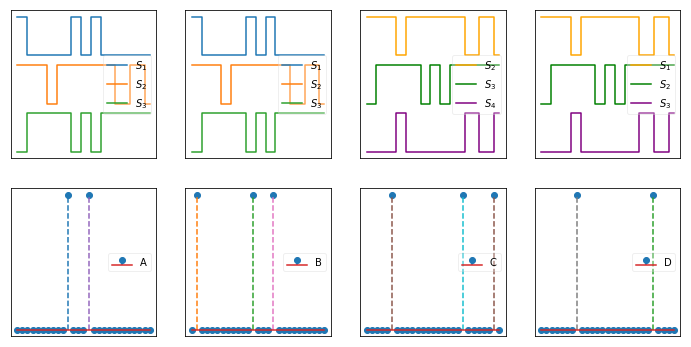

In [22]:
def posChart(ax):
    ax.legend(loc=7, framealpha=.3)
    ax.set_xticks([])
    ax.set_yticks([])

fig, ax = plt.subplots(2, 4, figsize=(12,6))

ax[0][0].step(range(s1.size), s1+3.75, where='post', label='$S_1$')
ax[0][0].step(range(s2.size), s2+2.5, where='post', label='$S_2$')
ax[0][0].step(range(s3.size), s3+1.25, where='post', label='$S_3$')
posChart(ax[0][0])

ax[1][0].stem(range(1, s1.size), stateA, linefmt='--', label='A')
posChart(ax[1][0])

ax[0][1].step(range(s1.size), s1+3.75, where='post', label='$S_1$')
ax[0][1].step(range(s1.size), s2+2.5, where='post', label='$S_2$')
ax[0][1].step(range(s1.size), s3+1.25, where='post', label='$S_3$')
posChart(ax[0][1])

ax[1][1].stem(range(1, s1.size), stateB, linefmt='--', label='B')
posChart(ax[1][1])



ax[0][2].step(range(s1.size), s2+3.75, where='post', label='$S_2$', color='orange')
ax[0][2].step(range(s2.size), s3+2.5, where='post', label='$S_3$', color='green')
ax[0][2].step(range(s3.size), s4+1.25, where='post', label='$S_4$', color='purple')
posChart(ax[0][2])

ax[1][2].stem(range(1, s1.size), stateC, linefmt='--', label='C')
posChart(ax[1][2])

ax[0][3].step(range(s1.size), s2+3.75, where='post', label='$S_1$', color='orange')
ax[0][3].step(range(s1.size), s3+2.5, where='post', label='$S_2$', color='green')
ax[0][3].step(range(s1.size), s4+1.25, where='post', label='$S_3$', color='purple')
posChart(ax[0][3])

ax[1][3].stem(range(1, s1.size), stateD, linefmt='--', label='D')
posChart(ax[1][3])

plt.legend(loc=7, framealpha=.3)
xmin, _ = plt.xlim()
plt.show()

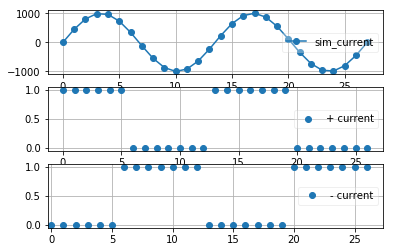

In [23]:
fig, ax = plt.subplots(3, 1)
ax[0].plot(sim_current, '-o', label='sim_current')
ax[0].legend(loc=7, framealpha=.3)
ax[0].grid()
ax[1].plot(current_pos, 'o', label='+ current')
ax[1].legend(loc=7, framealpha=.3)
ax[1].grid()
ax[2].plot(current_neg, 'o', label='- current')
ax[2].legend(loc=7, framealpha=.3)
ax[2].grid()

_, xmax = plt.xlim()
plt.xlim(xmin, xmax)
plt.show()

### 6. Multiplicação dos vetores de comutação e sentido da corrente para para setar o estado em comutação ocorreu e acumular devidamente $E_{on}$,  $E_{off}$ e $E_{rec}$ & Os vetores de corrente para cada estágio em que as comutações ocorreram

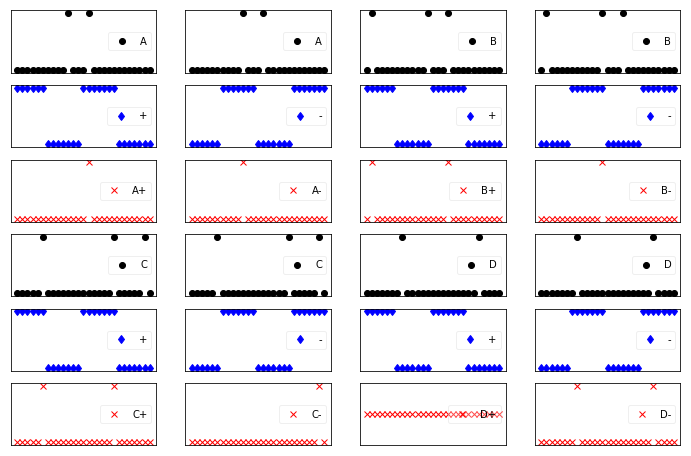

In [24]:
def posChart(ax):
    ax.legend(loc=7, framealpha=.3)
    ax.set_xticks([])
    ax.set_yticks([])

fig, ax = plt.subplots(6, 4, figsize=(12,8))

for axt in [ax[0][0], ax[0][1]]:
    axt.plot(stateA, 'ko ', label='A')
    posChart(axt)

for axt in [ax[0][2], ax[0][3]]:
    axt.plot(stateB, 'ko ', label='B')
    posChart(axt)

for axt in [ax[3][0], ax[3][1]]:
    axt.plot(stateC, 'ko ', label='C')
    posChart(axt)

for axt in [ax[3][2], ax[3][3]]:
    axt.plot(stateD, 'ko ', label='D')
    posChart(axt)

#%%
    
for axt in [ax[1][0], ax[1][2], ax[4][0], ax[4][2]]:
    axt.plot(current_pos, 'bd ', label='+')
    posChart(axt)

for axt in [ax[1][1], ax[1][3], ax[4][1], ax[4][3]]:
    axt.plot(current_neg, 'bd ', label='-')
    posChart(axt)

#%%

for axt, y, label in zip([ax[2][0], ax[2][1], ax[2][2], ax[2][3], ax[5][0], ax[5][1], ax[5][2], ax[5][3]],
                  [stateA_cur_pos, stateA_cur_neg, stateB_cur_pos, stateB_cur_neg, 
                   stateC_cur_pos, stateC_cur_neg, stateD_cur_pos, stateD_cur_neg],
                  ['A+', 'A-', 'B+', 'B-', 'C+', 'C-', 'D+', 'D-']):
    axt.plot(y, 'rx ', label=label)
    posChart(axt)


### 7. Resultado Final das potências dissipadas de cada um dos semicondutores $S_1$, $S_2$, $D_1$ e $D_2$ , em Watts

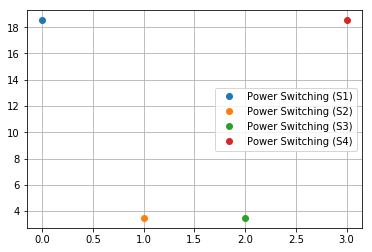

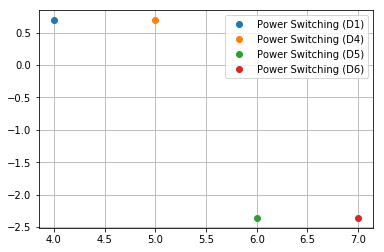

In [25]:
plt.plot([0], P_sw['S1'], 'o', label='Power Switching (S1)')
plt.plot([1], P_sw['S2'], 'o', label='Power Switching (S2)')
plt.plot([2], P_sw['S3'], 'o', label='Power Switching (S3)')
plt.plot([3], P_sw['S4'], 'o', label='Power Switching (S4)')
plt.grid()
plt.legend()
plt.show()

plt.plot([4], P_sw['D1'], 'o', label='Power Switching (D1)')
plt.plot([5], P_sw['D4'], 'o', label='Power Switching (D4)')
plt.plot([6], P_sw['D5'], 'o', label='Power Switching (D5)')
plt.plot([7], P_sw['D6'], 'o', label='Power Switching (D6)')
plt.grid()
plt.legend()
plt.show()

### Ap. Gráfico com os polinômios gerados para cada equação de energia

In [26]:
i = np.linspace(0, 1000, 200)

eon  = eon2
eoff = eoff2
erec = erec2

In [27]:
eon_p  = eon(i)
eoff_p = eoff(i)
erec_p = erec(i)

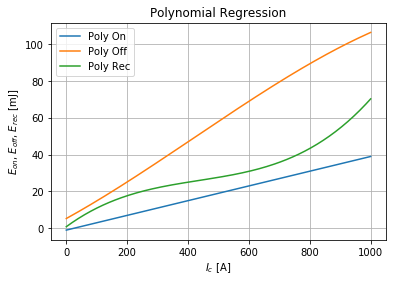

In [28]:
plt.plot(i, eon_p *1e3, label='Poly On')
plt.plot(i, eoff_p*1e3, label='Poly Off')
plt.plot(i, erec_p*1e3, label='Poly Rec')
plt.title('Polynomial Regression') 
plt.xlabel('$I_c$ [A]') 
plt.ylabel('$E_{on}$, $E_{off}$, $E_{rec}$ [mJ]')
plt.grid()
plt.legend()
# plt.xlim(100, 600)
plt.show()

## Testing the Conduction Losses

In [29]:
def rmsValue(current):
    '''
    Calculate the RMS value.
    '''
    
    import numpy as np
    
    return np.sqrt(np.sum(np.power(current, 2)) / current.size)

In [45]:
def tableConductionLosses3(switch_s1, switch_s2, current, 
                           Vo_IGBT1, Vo_IGBT2, 
                           Vo_Diode1, Vo_Diode2, Vo_Diode,
                           Ro_IGBT1, Ro_IGBT2,
                           Ro_Diode1, Ro_Diode2, Ro_Diode5):
    '''
        Table with Conduction Losses for TDD 3-Levels.
    '''
    
    switch_s1 = np.array(switch_s1)
    switch_s2 = np.array(switch_s2)
    current = np.array(current)
    
    pos_current = np.zeros(current.size)
    neg_current = np.zeros(current.size)
    
    pos_current[current >= 0] = current[current >= 0]
    neg_current[current < 0]  = current[current < 0]
    
    S1_S2 = np.logical_and(switch_s1, switch_s2)
    S2_S3 = np.logical_and(np.logical_not(switch_s1), switch_s2)
    S3_S4 = np.logical_and(np.logical_not(switch_s1), np.logical_not(switch_s2))
    
    s1_times_current = switch_s1 * current
    s2_times_current = switch_s2 * current
        
    
    current_S1_S2 = np.zeros(current.size)
    current_D1_D2 = np.zeros(current.size)
    
    current_S2_D5 = np.zeros(current.size)
    current_S3_D6 = np.zeros(current.size)
    
    current_D3_D4 = np.zeros(current.size)
    current_S3_S4 = np.zeros(current.size)

    ###
    
    current_S1_S2 = pos_current * S1_S2
    current_D1_D2 = neg_current * S1_S2
    
    current_S2_D5 = pos_current * S2_S3
    current_S3_D6 = neg_current * S2_S3
    
    current_D3_D4 = pos_current * S3_S4
    current_S3_S4 = neg_current * S3_S4
    
    s1_cd = Vo_IGBT1  * np.mean(current_S1_S2) + Ro_IGBT1  * np.power(rmsValue(current_S1_S2), 2) 
    s2_cd = Vo_IGBT2  * np.mean(current_S1_S2) + Ro_IGBT2  * np.power(rmsValue(current_S1_S2), 2) + \
            Vo_IGBT2  * np.mean(current_S2_D5) + Ro_IGBT2  * np.power(rmsValue(current_S2_D5), 2)
    
    s3_cd = Vo_IGBT2  * np.mean(current_S3_D6) + Ro_IGBT2  * np.power(rmsValue(current_S3_D6), 2) + \
            Vo_IGBT2  * np.mean(current_S3_S4) + Ro_IGBT2  * np.power(rmsValue(current_S3_S4), 2)
    s4_cd = Vo_IGBT1  * np.mean(current_S3_S4) + Ro_IGBT1  * np.power(rmsValue(current_S3_S4), 2)
    
    d1_cd = Vo_Diode1 * np.mean(current_D1_D2) + Ro_Diode1 * np.power(rmsValue(current_D1_D2), 2)
    d2_cd = Vo_Diode2 * np.mean(current_D1_D2) + Ro_Diode2 * np.power(rmsValue(current_D1_D2), 2)
    
    d3_cd = Vo_Diode2 * np.mean(current_D3_D4) + Ro_Diode2 * np.power(rmsValue(current_D3_D4), 2)
    d4_cd = Vo_Diode1 * np.mean(current_D3_D4) + Ro_Diode1 * np.power(rmsValue(current_D3_D4), 2)

    d5_cd = Vo_Diode5 * np.mean(current_S2_D5) + Ro_Diode5 * np.power(rmsValue(current_S2_D5), 2)
    d6_cd = Vo_Diode5 * np.mean(current_S3_D6) + Ro_Diode5 * np.power(rmsValue(current_S3_D6), 2)
    
    P_cd = {'S1': s1_cd,
            'S2': s2_cd,
            'S3': s3_cd,
            'S4': s4_cd,
            'D1': d1_cd,
            'D2': d2_cd,
            'D3': d3_cd,
            'D4': d4_cd,
            'D5': d5_cd,
            'D6': d6_cd}
    
    return P_cd, ((switch_s1, switch_s2), 
                  (current_S1_S2, current_D1_D2, 
                   current_S2_D5, current_S3_D6, 
                   current_D3_D4, current_S3_S4),
                  (rmsValue(current_S1_S2), rmsValue(current_D1_D2), 
                   rmsValue(current_S2_D5), rmsValue(current_S3_D6),
                   rmsValue(current_D3_D4), rmsValue(current_S3_S4)))

### 1. Generating the signals for test

In [46]:
Vdc = 800

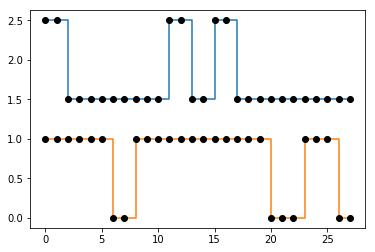

In [47]:
t = np.arange(0, s1.size, 1)

plt.step(t, s1+1.5, where='post')
plt.plot(s1+1.5, 'ko')
plt.step(t, s2, where='post')
plt.plot(s2, 'ko')
plt.show()

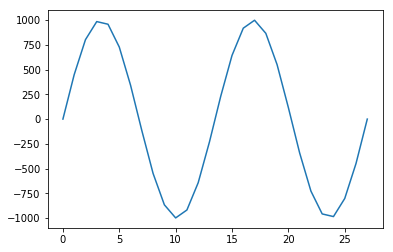

In [48]:
plt.plot(sim_current)

In [49]:
P_cd, tmp = tableConductionLosses3(s1, s2, sim_current, 
                                    Vo_IGBT1, Vo_IGBT2, 
                                    Vo_Diode1, Vo_Diode2, Vo_Diode2,
                                    Ro_IGBT1, Ro_IGBT2,
                                    Ro_Diode1, Ro_Diode2, Ro_Diode5)
switchs, currents, rms_currents = tmp

switch_s1, switch_s2 = switchs

current_S1_S2, current_D1_D2, \
current_S2_D5, current_S3_D6, \
current_D3_D4, current_S3_S4 = currents

rms_current_S1_S2, rms_current_D1_D2, \
rms_current_S2_D5, rms_current_S3_D6, \
rms_current_D3_D4, rms_current_S3_S4 = rms_currents

### 4. Plots que mostram que os semicondutores estão conduzindo nos momentos certos e no sentido correto da corrente

(-1100, 1100)

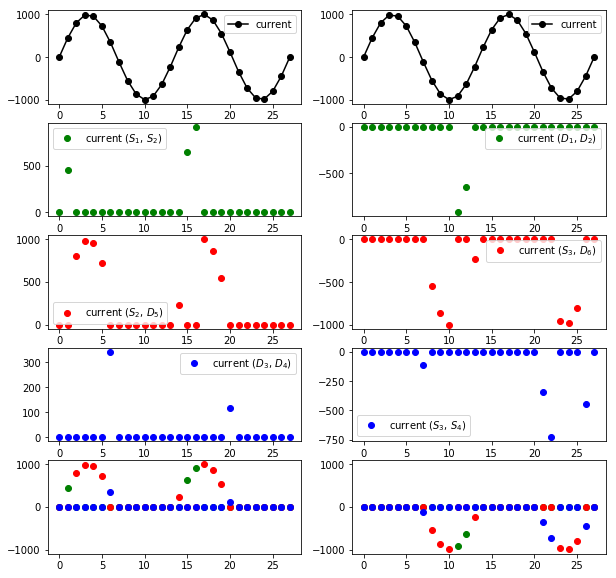

In [59]:
fig, ax = plt.subplots(5, 2, figsize=(10, 10))

plots = [sim_current, current_S1_S2, current_S2_D5, current_D3_D4, 
         sim_current, current_D1_D2, current_S3_D6, current_S3_S4]
coors = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]
labels = ['current', 'current ($S_1$, $S_2$)', 'current ($S_2$, $D_5$)', 'current ($D_3$, $D_4$)', 
          'current', 'current ($D_1$, $D_2$)', 'current ($S_3$, $D_6$)', 'current ($S_3$, $S_4$)']
colors = ['ko-', 'go', 'ro', 'bo', 'ko-', 'go', 'ro', 'bo']
for coord, plot, label, color in zip(coors, plots, labels, colors):
    ax[coord[1]][coord[0]].plot(plot, color, label=label)
    ax[coord[1]][coord[0]].legend()

ax[4][0].plot(current_S1_S2, 'go')
ax[4][0].plot(current_S2_D5, 'ro')
ax[4][0].plot(current_D3_D4, 'bo')
ax[4][0].set_ylim(-1100, 1100)
ax[4][1].plot(current_D1_D2, 'go')
ax[4][1].plot(current_S3_D6, 'ro')
ax[4][1].plot(current_S3_S4, 'bo')
ax[4][1].set_ylim(-1100, 1100)

### 5. Plot que mostram o valor RMS para cada uma das correntes avaliadas

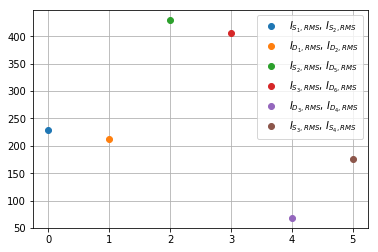

In [61]:
rms_current_S1_S2, rms_current_D1_D2, \
rms_current_S2_D5, rms_current_S3_D6, \
rms_current_D3_D4, rms_current_S3_S4

plt.plot([0], rms_current_S1_S2, 'o', label='$I_{S_1, RMS}$, $I_{S_2, RMS}$')
plt.plot([1], rms_current_D1_D2, 'o', label='$I_{D_1, RMS}$, $I_{D_2, RMS}$')
plt.plot([2], rms_current_S2_D5, 'o', label='$I_{S_2, RMS}$, $I_{D_5, RMS}$')
plt.plot([3], rms_current_S3_D6, 'o', label='$I_{S_3, RMS}$, $I_{D_6, RMS}$')
plt.plot([4], rms_current_D3_D4, 'o', label='$I_{D_3, RMS}$, $I_{D_4, RMS}$')
plt.plot([5], rms_current_S3_S4, 'o', label='$I_{S_3, RMS}$, $I_{S_4, RMS}$')
plt.legend()
plt.grid()
plt.show()

### 6. Resultado Final, as perdas em comutação para cada uma dos semicondutores, em Watts

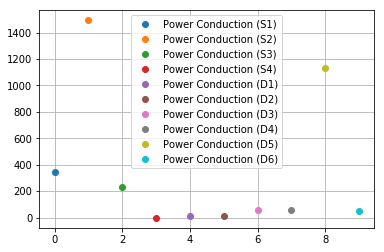

In [62]:
plt.plot([0], P_cd['S1'], 'o', label='Power Conduction (S1)')
plt.plot([1], P_cd['S2'], 'o', label='Power Conduction (S2)')
plt.plot([2], P_cd['S3'], 'o', label='Power Conduction (S3)')
plt.plot([3], P_cd['S4'], 'o', label='Power Conduction (S4)')
plt.plot([4], P_cd['D1'], 'o', label='Power Conduction (D1)')
plt.plot([5], P_cd['D2'], 'o', label='Power Conduction (D2)')
plt.plot([6], P_cd['D3'], 'o', label='Power Conduction (D3)')
plt.plot([7], P_cd['D4'], 'o', label='Power Conduction (D4)')
plt.plot([8], P_cd['D5'], 'o', label='Power Conduction (D5)')
plt.plot([9], P_cd['D6'], 'o', label='Power Conduction (D6)')
plt.grid()
plt.legend()
plt.show()